# CCC with Tensor-Cell2cell





In [2]:
!pip install --quiet liana cell2cell decoupler omnipath seaborn==0.11

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85

In [3]:
import pandas as pd
import scanpy as sc
import plotnine as p9

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway enrichment

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

%matplotlib inline


In [4]:
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend('pytorch')
else:
    device = "cpu"

device

'cuda'

In [5]:
adata = li.testing.datasets.kang_2018()

  0%|          | 0.00/36.6M [00:00<?, ?B/s]

In [6]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [8]:
adata.obs

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,patient,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters,sample,cell_abbr
index,,,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1,ctrl&1016,CD14
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1,ctrl&1256,CD14
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6,ctrl&1488,CD4T
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1,ctrl&1256,CD14
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12,ctrl&1039,DCs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCCTGAA-2,1033.0,468,18.268321,1.058202,stim,6,CD4 T cells,patient_1244,1128.0,468,2,2,stim&1244,CD4T
TTTGCATGCCTGTC-2,2116.0,819,-11.563067,2.574095,stim,4,B cells,patient_1256,1669.0,799,3,3,stim&1256,B
TTTGCATGCTAAGC-2,1522.0,523,25.142392,6.603815,stim,6,CD4 T cells,patient_107,1422.0,523,0,0,stim&107,CD4T


In [9]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_type'

In [10]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

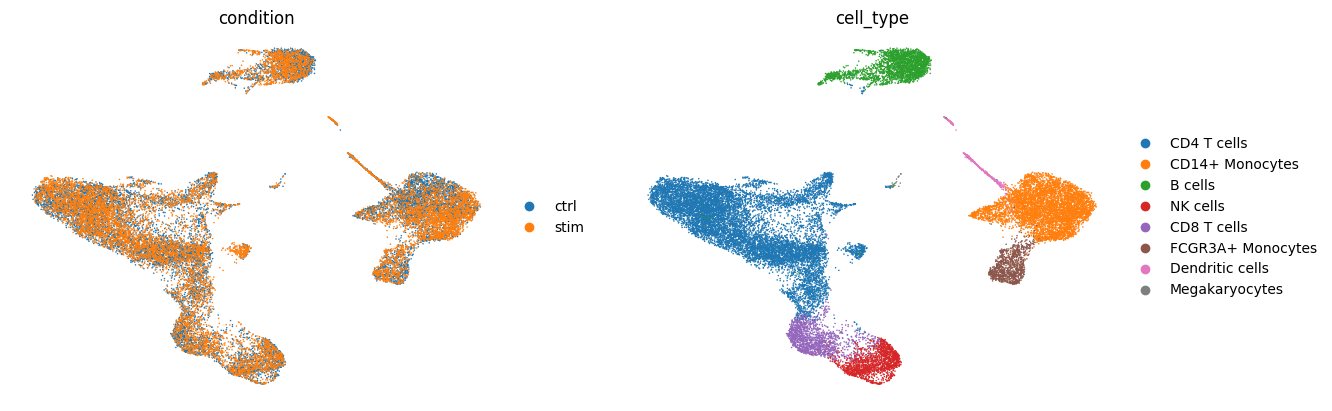

In [11]:
sc.pl.umap(adata, color=[condition_key, groupby], frameon=False)

In [12]:
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr', 'n_genes'
    var: 'name', 'n_cells'
    uns: 'log1p', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [13]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name='consensus', # NOTE: uses human gene symbols!
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=None, # exclude permutations for speed
    return_all_lrs=True, # return all LR values
    )

Now running: stim&1488: 100%|██████████| 16/16 [02:12<00:00,  8.30s/it]


In [14]:
adata.uns["liana_res"].sort_values("magnitude_rank").head(10)

,sample,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
328398,ctrl&1488,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.380374,4.891490,1.928655,2.288309,0.129141,0.984287,1.151878e-08
464128,stim&1015,NK cells,NK cells,B2M,KLRD1,2.471536,2.552514,1.650699,0.789530,0.096218,0.977725,1.176411e-08
222411,ctrl&1244,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.504210,5.661785,1.703509,2.209408,0.116978,0.985015,1.284372e-08
138180,ctrl&1016,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.299348,4.729413,1.456102,1.823954,0.112280,0.983242,1.449280e-08
646800,stim&1256,NK cells,NK cells,B2M,KLRD1,2.561136,2.982985,1.479990,0.931471,0.089038,0.979089,1.467004e-08
0,ctrl&101,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.627803,6.208072,1.545891,2.279768,0.132816,0.984116,1.765464e-08
186788,ctrl&1039,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.547695,5.674415,1.301281,1.767435,0.104337,0.981838,2.530672e-08
43757,ctrl&107,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.544711,5.852476,1.065290,1.678028,0.104096,0.982827,2.729847e-08
464129,stim&1015,CD8 T cells,NK cells,B2M,KLRD1,2.458305,2.537012,1.609142,0.755273,0.095633,0.977658,4.705531e-08
138181,ctrl&1016,CD14+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.284614,4.683657,1.445400,2.444503,0.111194,0.983162,5.796964e-08


In [15]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|██████████| 16/16 [00:55<00:00,  3.50s/it]


In [18]:
tensor.tensor.shape

torch.Size([16, 418, 7, 7])

In [19]:
adata.obs["sample"].unique()

['ctrl&1016', 'ctrl&1256', 'ctrl&1488', 'ctrl&1039', 'ctrl&1015', ..., 'stim&1015', 'stim&1016', 'stim&1244', 'stim&1039', 'stim&107']
Length: 16
Categories (16, object): ['ctrl&101', 'ctrl&107', 'ctrl&1015', 'ctrl&1016', ..., 'stim&1039',
                          'stim&1244', 'stim&1256', 'stim&1488']

In [20]:
adata.uns["liana_res"].shape

(748524, 12)

In [21]:
c2c.io.export_variable_with_pickle(tensor, "tensor_tutorial.pkl")

tensor_tutorial.pkl  was correctly saved.


In [23]:
ls -lh

total 42M
-rw-r--r-- 1 root root  37M Aug 20 05:58 kang_counts_25k.h5ad
drwxr-xr-x 1 root root 4.0K Aug 16 13:21 sample_data/
-rw-r--r-- 1 root root 5.1M Aug 20 06:13 tensor_tutorial.pkl


In [24]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [27]:
context_dict

defaultdict(<function __main__.<lambda>()>,
            {'ctrl&1016': 'ctrl',
             'ctrl&1256': 'ctrl',
             'ctrl&1488': 'ctrl',
             'ctrl&1039': 'ctrl',
             'ctrl&1015': 'ctrl',
             'ctrl&107': 'ctrl',
             'ctrl&1244': 'ctrl',
             'ctrl&101': 'ctrl',
             'stim&101': 'stim',
             'stim&1488': 'stim',
             'stim&1256': 'stim',
             'stim&1015': 'stim',
             'stim&1016': 'stim',
             'stim&1244': 'stim',
             'stim&1039': 'stim',
             'stim&107': 'stim'})

In [31]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device=device, # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


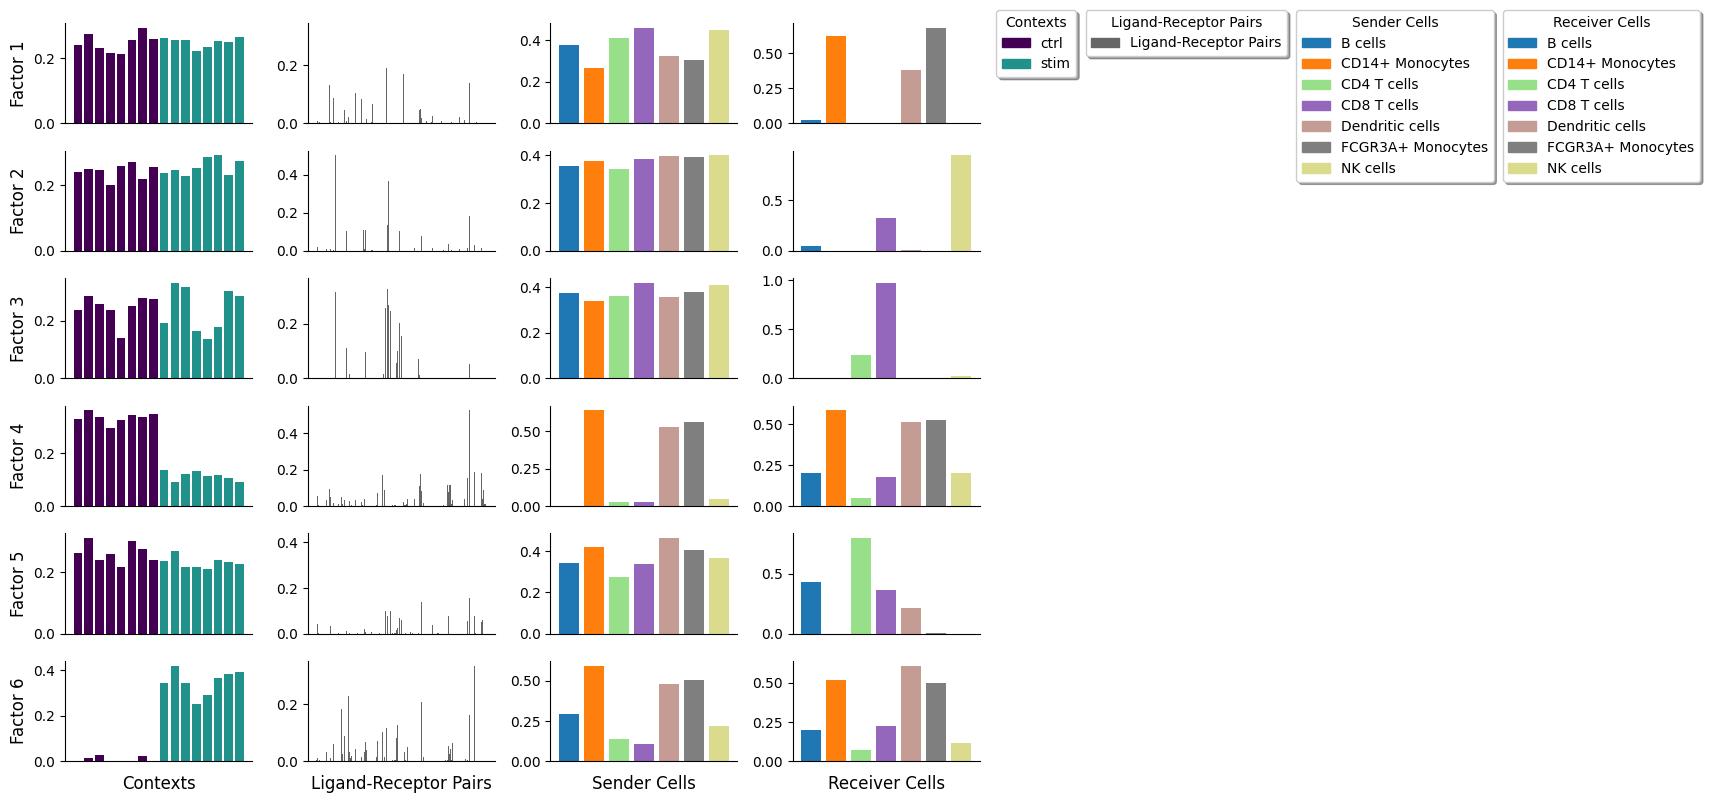

In [36]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [37]:
factors = tensor.factors

(<Figure size 800x600 with 6 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 2'}, ylabel=' '>,
         <Axes: title={'center': 'Factor 3'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 4'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 5'}, ylabel=' '>,
         <Axes: title={'center': 'Factor 6'}, ylabel=' '>]], dtype=object))

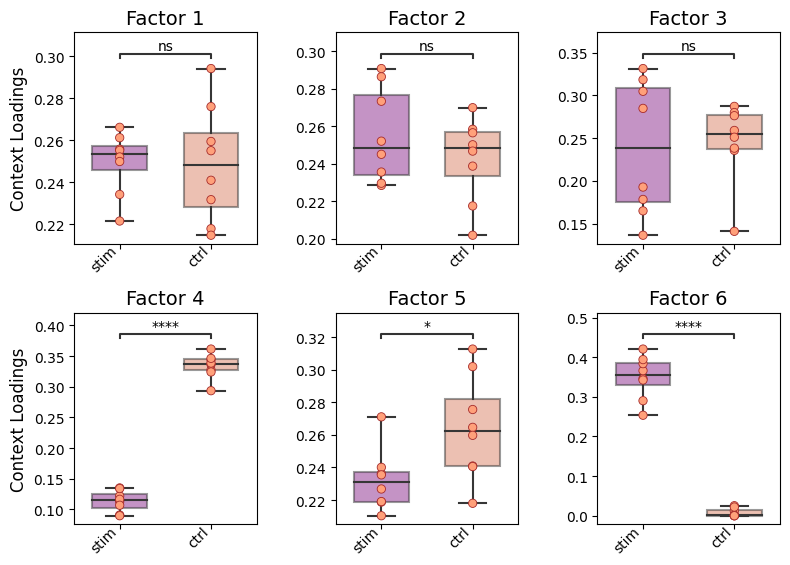

In [38]:
 c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(8, 6),
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False,
                                )

(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Factor 6'}>)

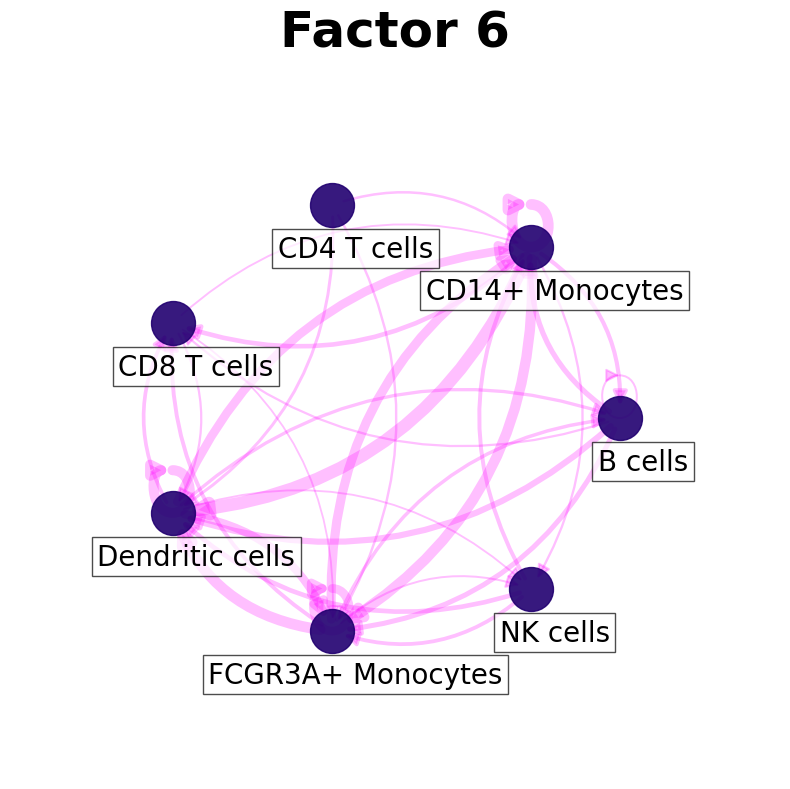

In [39]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 6'],
                               network_layout='circular',
                               ccc_threshold=0.05, # Only important communication
                               nrows=1,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )

In [40]:
lr_loadings = factors['Ligand-Receptor Pairs']
lr_loadings.sort_values("Factor 6", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
TNFSF13B^HLA-DPB1,0.000086,3.042804e-02,2.637282e-04,1.887632e-01,7.752963e-02,0.336778
LGALS9^CD47,0.025412,6.811806e-02,4.679689e-06,7.088498e-02,1.267167e-01,0.253341
TNFSF13B^CD40,0.003507,9.267304e-30,0.000000e+00,7.410809e-02,1.891911e-04,0.250370
LGALS9^PTPRC,0.021960,8.812850e-02,7.158520e-03,7.547465e-02,1.432858e-01,0.234254
LGALS1^CD69,0.023514,1.394061e-01,2.838764e-10,4.337768e-02,2.383830e-01,0.230074
CCL8^CCR1,0.022765,0.000000e+00,0.000000e+00,3.432690e-17,1.401298e-45,0.229074
CCL2^CCR1,0.001002,0.000000e+00,0.000000e+00,6.157767e-02,0.000000e+00,0.220899
LGALS9^CD44,0.019764,7.980247e-02,5.156275e-05,8.430903e-02,1.364834e-01,0.209243
CCL8^CCR5,0.016282,0.000000e+00,0.000000e+00,1.310904e-17,9.691676e-39,0.192050
LGALS9^HAVCR2,0.040072,5.730826e-02,6.960267e-10,5.063234e-02,9.982053e-19,0.187999


In [41]:
net = dc.get_progeny(organism='human', top=5000)

0.00B [00:00, ?B/s]

In [42]:
net

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
69995,p53,RGS9BP,0.842450,4.088961e-02
69996,p53,IRAG1,0.807761,4.089827e-02
69997,p53,ATP2B1,-2.320707,4.089862e-02
69998,p53,SNX29,0.985361,4.091074e-02


In [43]:
lr_pairs = li.resource.select_resource('consensus')

In [44]:
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
844,JAK-STAT,LGALS9^CD47,2.054778
1130,Trail,LGALS9^PTPRK,0.937003
1432,JAK-STAT,LGALS9^HAVCR2,1.487678
1779,EGFR,DLL1^NOTCH1,-1.000584


In [45]:
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

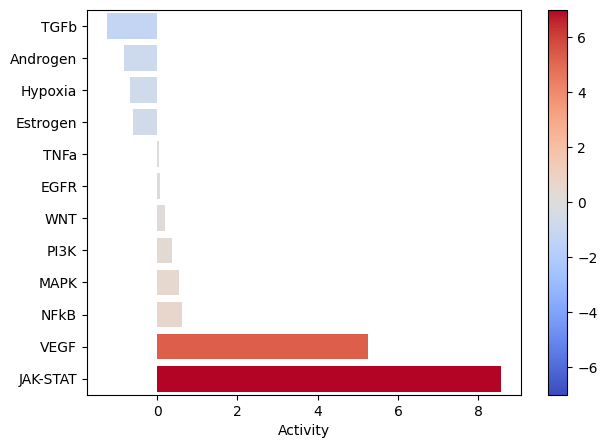

In [46]:
dc.plot_barplot(estimate, 'Factor 6', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)

In [47]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

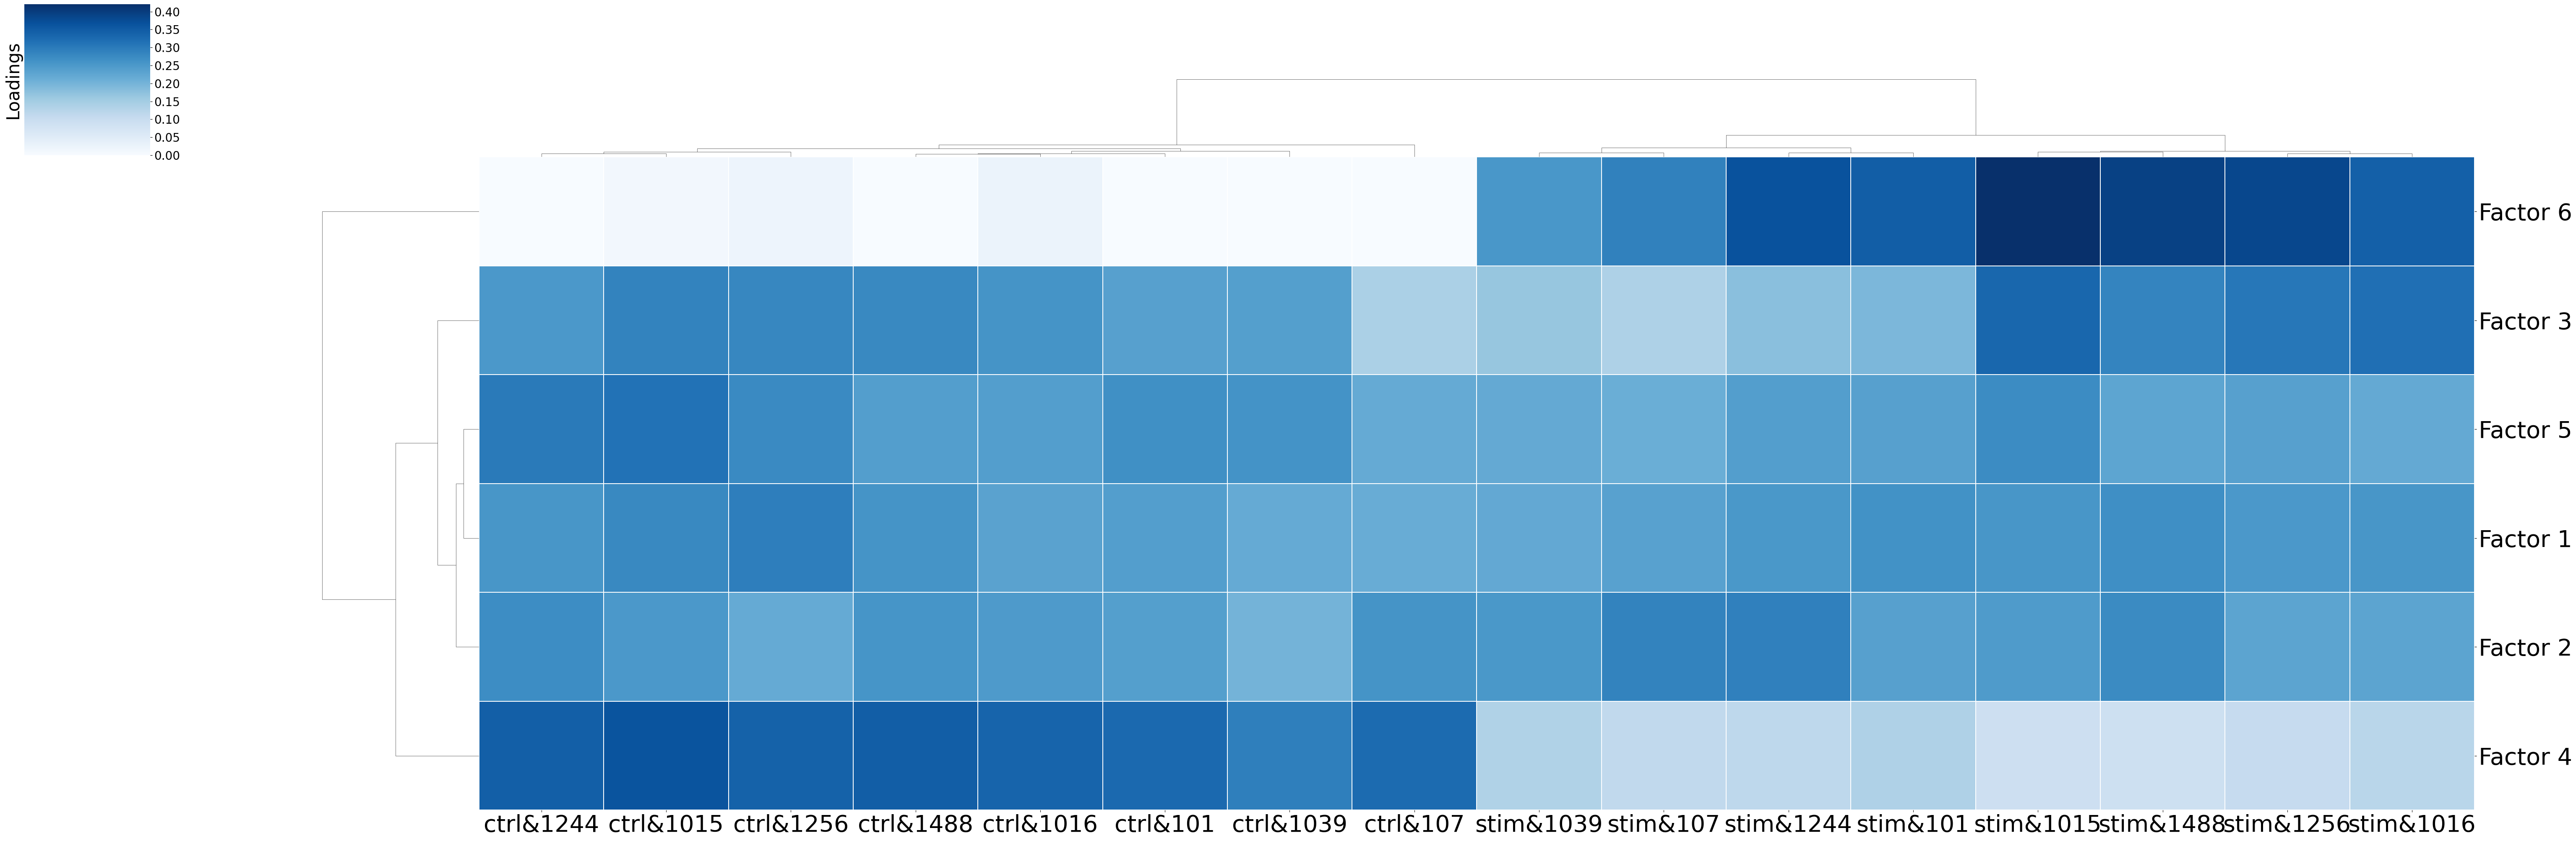

In [55]:
import matplotlib.pyplot as plt
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=False,
                                            figsize=(60, 20),
                                            dendrogram_ratio=0.2,
                                            cbar_fontsize=30,
                                            tick_fontsize=20
                                           )
plt.setp(sample_cm.ax_heatmap.get_xticklabels(), fontsize=40)
plt.setp(sample_cm.ax_heatmap.get_yticklabels(), fontsize=40)
plt.setp(sample_cm.cax.yaxis.get_ticklabels(), fontsize=20)

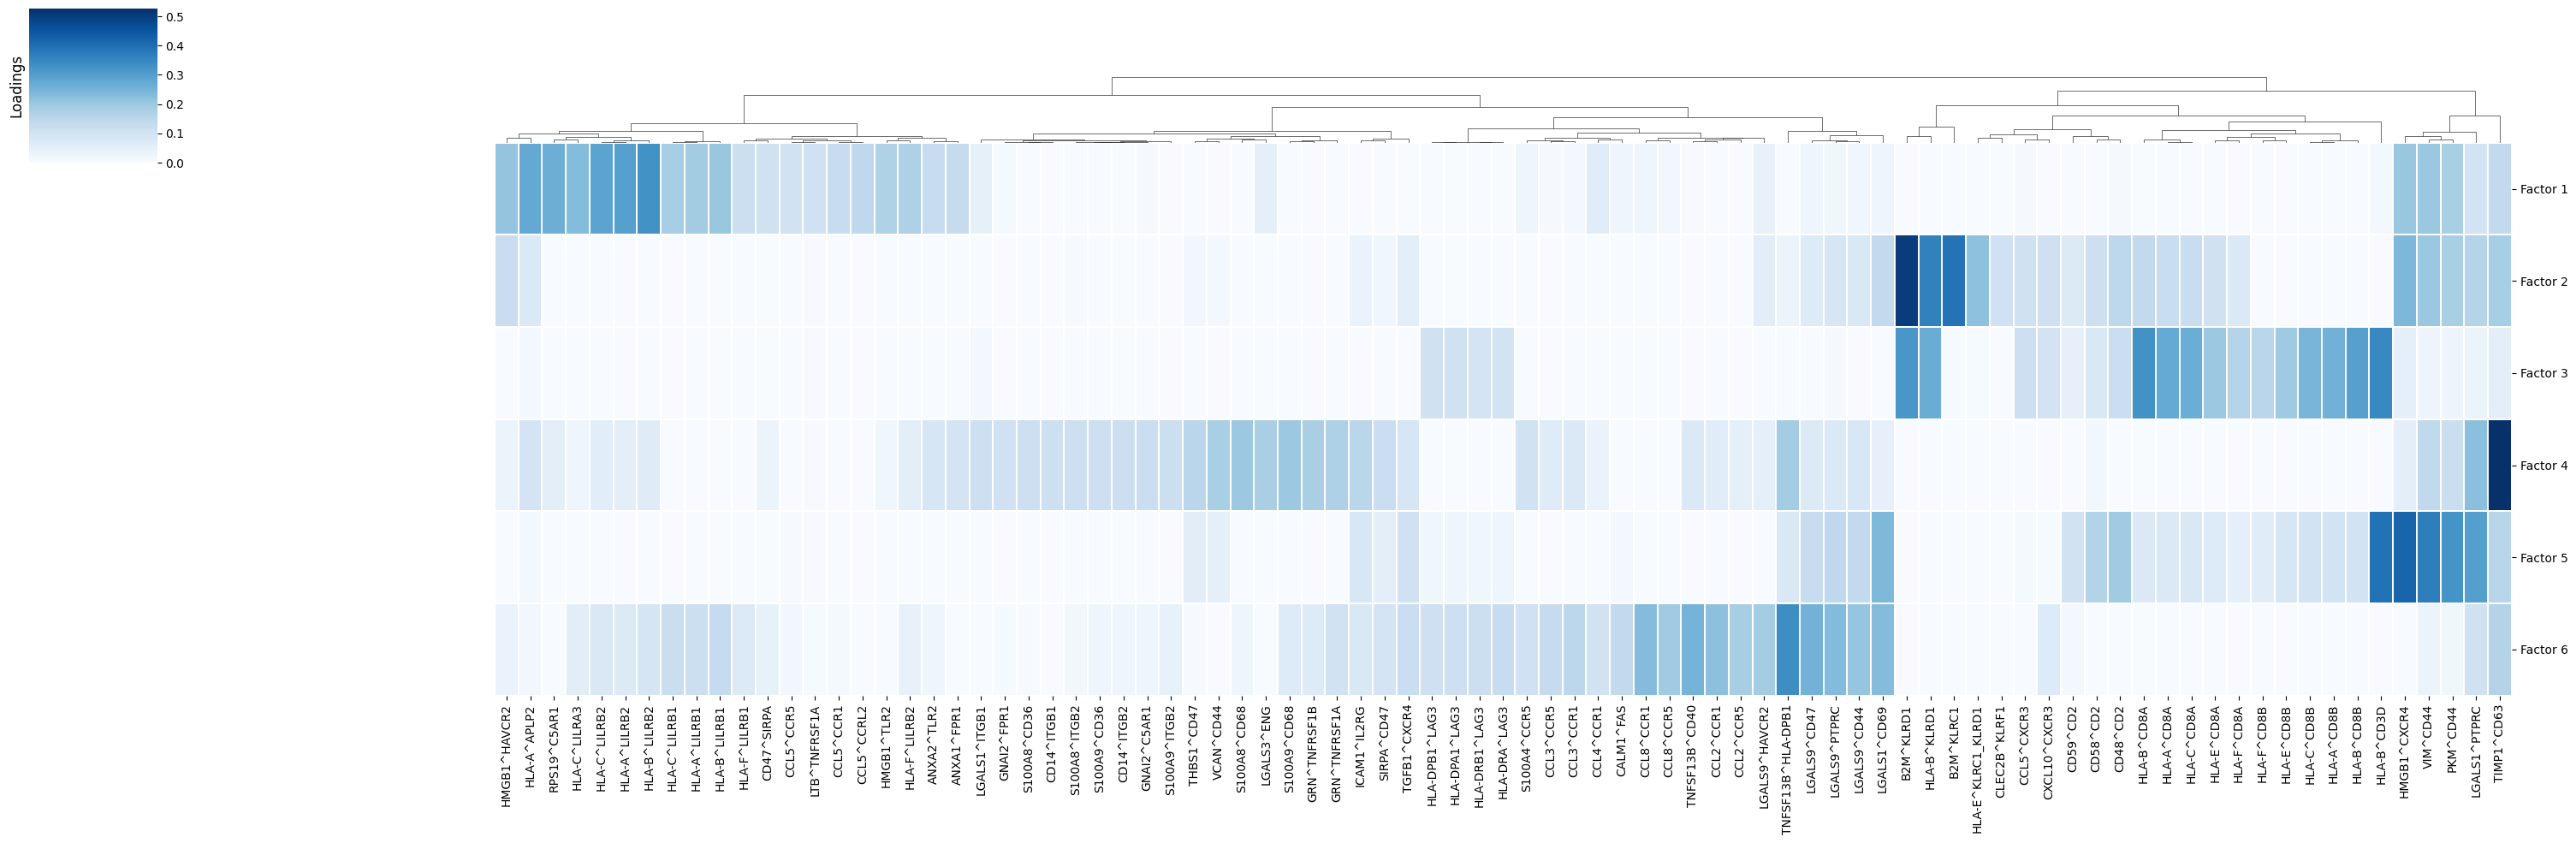

In [60]:
c2c.plotting.loading_clustermap(factors['Ligand-Receptor Pairs'],
                                        loading_threshold=0.1, # To consider only top LRs
                                        use_zscore=False, # Whether standardizing the loadings across factors
                                        figsize=(30, 10),
                                        row_cluster=False # To avoid clustering of factors
                                       )

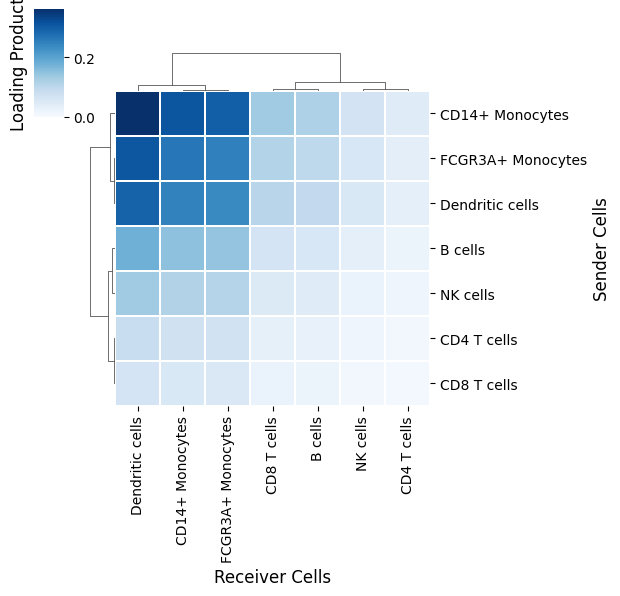

In [63]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor='Factor 6',
                                                                   )

c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(6, 6),
                                           cbar_label='Loading Product',
                                          )

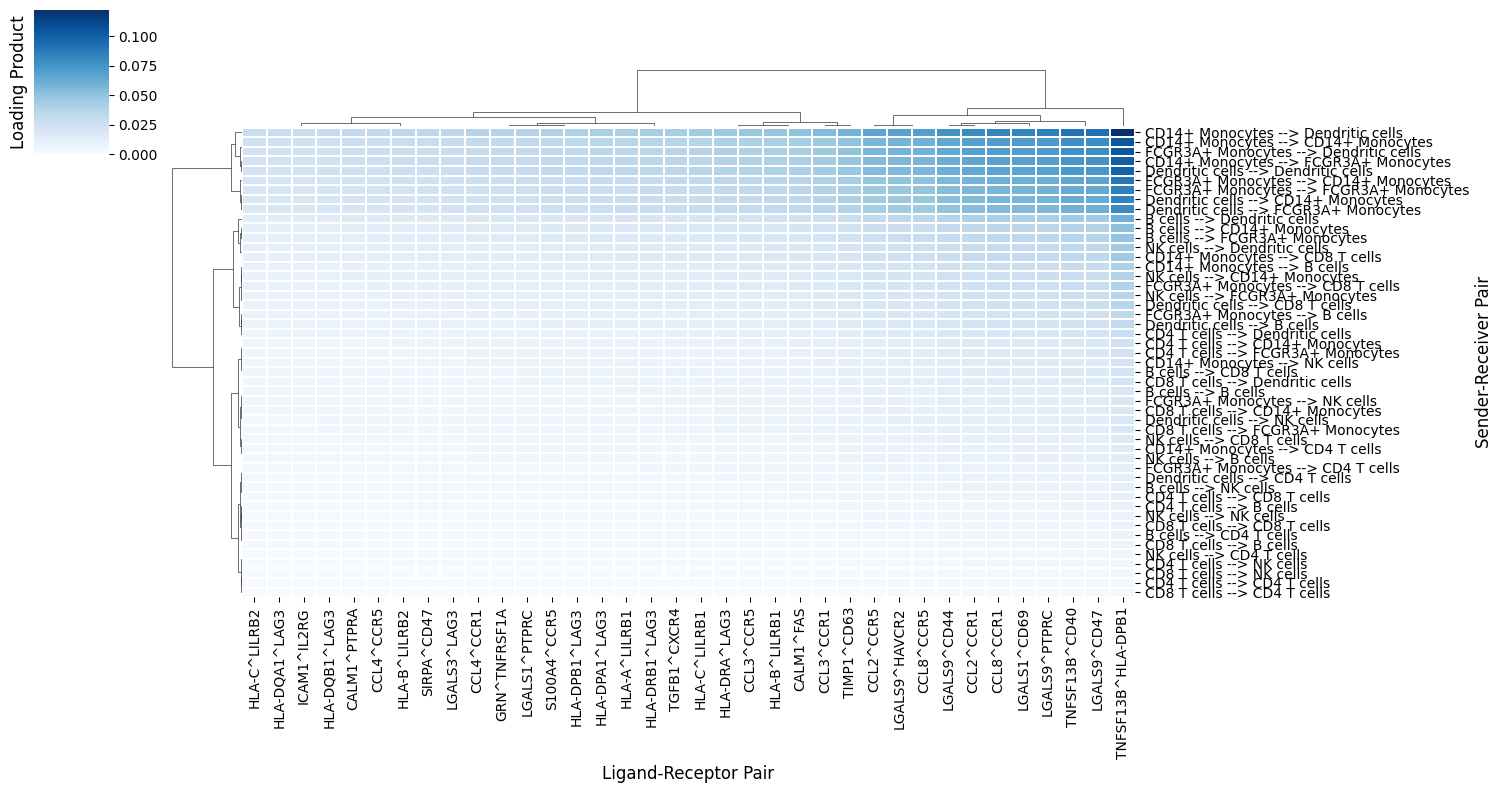

In [66]:
lr_cell_product = c2c.analysis.tensor_downstream.get_lr_by_cell_pairs(factors,
                                                                      lr_label='Ligand-Receptor Pairs',
                                                                      sender_label='Sender Cells',
                                                                      receiver_label='Receiver Cells',
                                                                      order_cells_by='receivers',
                                                                      factor='Factor 6',
                                                                      cci_threshold=None, # None for considering all cell-cell pairs.
                                                                      lr_threshold=0.075 # Prioritize important pairs. None for considering all of them
                                                                     )
lsr_prod_cm = c2c.plotting.loading_clustermap(lr_cell_product,
                                              use_zscore=False,
                                              cbar_label='Loading Product',
                                              yticklabels=1
                                             )

# MOFA

In [67]:
# Store the counts to use them later
adata.layers["counts"] = adata.X.copy()

# Normalize and find marker genes per cell type
# We will use those to remove potential noise from the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby=groupby)

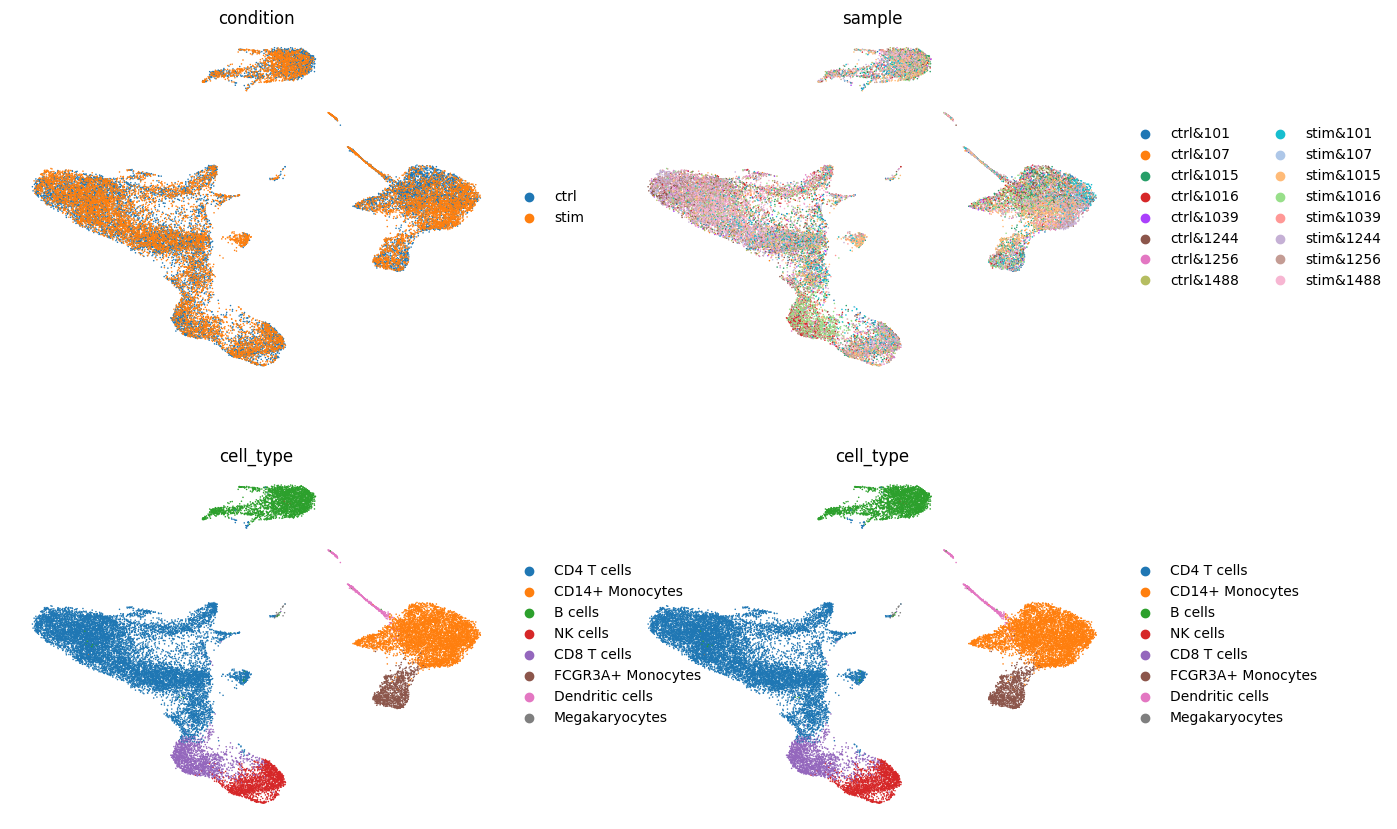

In [68]:
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

In [74]:
mdata = li.multi.adata_to_views(adata,
                                skip_checks=True,
                                groupby=groupby,
                                sample_key=sample_key,
                                keep_stats=True,
                                obs_keys=['condition', 'patient'], # add those to mdata.obs
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True,
                                large_n=5, # edgeR-like filtering
                                min_total_count=15,
                                min_count=10,
                                layer='counts',
                                )

100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


In [75]:
mdata.uns['psbulk_stats'].head()

,CD14+ Monocytes:psbulk_n_cells,CD14+ Monocytes:psbulk_counts,CD4 T cells:psbulk_n_cells,CD4 T cells:psbulk_counts,Dendritic cells:psbulk_n_cells,Dendritic cells:psbulk_counts,NK cells:psbulk_n_cells,NK cells:psbulk_counts,CD8 T cells:psbulk_n_cells,CD8 T cells:psbulk_counts,B cells:psbulk_n_cells,B cells:psbulk_counts,FCGR3A+ Monocytes:psbulk_n_cells,FCGR3A+ Monocytes:psbulk_counts
ctrl&101,207.0,103912.820312,353.0,171127.984375,25.0,14373.270508,65.0,32618.105469,29.0,14161.833008,106.0,54216.003906,72.0,36356.472656
ctrl&1015,859.0,400933.906250,951.0,468679.906250,40.0,22909.585938,179.0,92452.734375,85.0,43318.730469,459.0,232211.609375,164.0,84293.765625
ctrl&1016,393.0,193613.859375,502.0,245548.250000,27.0,14955.491211,90.0,44444.617188,504.0,240829.390625,125.0,63126.605469,81.0,41972.164062
ctrl&1039,126.0,60247.589844,201.0,100336.968750,NaN,NaN,NaN,NaN,NaN,NaN,26.0,13276.266602,NaN,NaN
ctrl&107,210.0,99269.773438,180.0,86582.039062,NaN,NaN,37.0,18236.878906,NaN,NaN,44.0,22334.580078,NaN,NaN


In [76]:
markers = {}
top_n = 25
for cell_type in mdata.mod.keys():
    markers[cell_type] = (sc.get.rank_genes_groups_df(adata, group=cell_type).
                          sort_values("scores", key=abs, ascending=False).
                          head(top_n)['names'].
                          tolist()
                          )

In [78]:
li.multi.filter_view_markers(mdata, markers=markers, var_column=None, inplace=True)
mdata.update()

In [80]:
for view in mdata.mod.keys():

    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])

    sc.pp.highly_variable_genes(mdata.mod[view])

In [82]:
!pip install --quiet mofax
!pip install --quiet muon
!pip install --quiet omnipath
!pip install --quiet marsilea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00


In [85]:
!pip install --q mofapy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00


In [86]:
import muon as mu
import mofax as mofa

mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           n_factors=5,
           seed=1337,
           outfile='models/mofacellx.h5ad',
           use_var='highly_variable'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CD14+ Monocytes' group='group1' with N=16 samples and D=2439 features...
Loaded view='CD4 T cells' group='group1' with N=16 samples and D=4568 features...
Loaded view='Dendritic cells' group='group1' with N=16 samples and D=338 features...
Loaded view='NK cells' group='group1' with N=16 samples and D=1071 features...
Loaded view='CD8 T cells' group='group1' with N=1

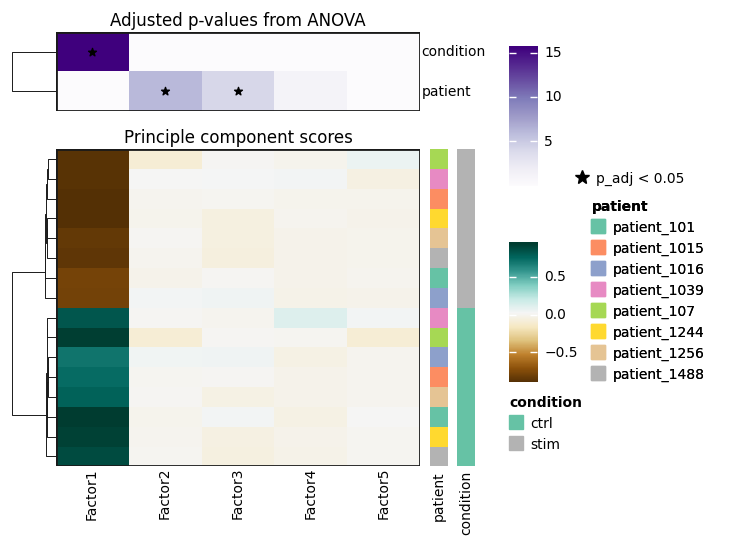

In [87]:
dc.get_metadata_associations(
    mdata,
    obs_keys = ['patient', 'condition'],  # Metadata columns to associate to PCs
    obsm_key='X_mofa',  # Where the PCs are stored
    uns_key='mofa_anova',  # Where the results are stored
    inplace=True,
)

dc.plot_associations(
    mdata,
    uns_key='mofa_anova',  # Summary statistics from the anova tests
    obsm_key='X_mofa',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['patient', 'condition'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

In [88]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=['condition', 'patient'])
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,condition,patient
0,ctrl&101,0.946078,-0.003581,0.040457,-0.032524,0.026852,ctrl,patient_101
1,ctrl&1015,0.741955,0.013807,0.016774,-0.009001,0.006038,ctrl,patient_1015
2,ctrl&1016,0.706097,0.047754,0.055872,-0.029669,0.002157,ctrl,patient_1016
3,ctrl&1039,0.825361,0.015760,0.005713,0.124714,0.036357,ctrl,patient_1039
4,ctrl&107,0.937951,-0.087886,0.014918,0.010284,-0.092806,ctrl,patient_107


In [89]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

In [90]:

# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))

TtestResult(statistic=45.25473676445312, pvalue=6.722277660440983e-10, df=7)
TtestResult(statistic=2.032896823045429, pvalue=0.08156338112297437, df=7)
TtestResult(statistic=0.8342374804506574, pvalue=0.4316915515673395, df=7)
TtestResult(statistic=0.35062084675043353, pvalue=0.736187205244921, df=7)
TtestResult(statistic=-0.007542393318839579, pvalue=0.9941925490348767, df=7)


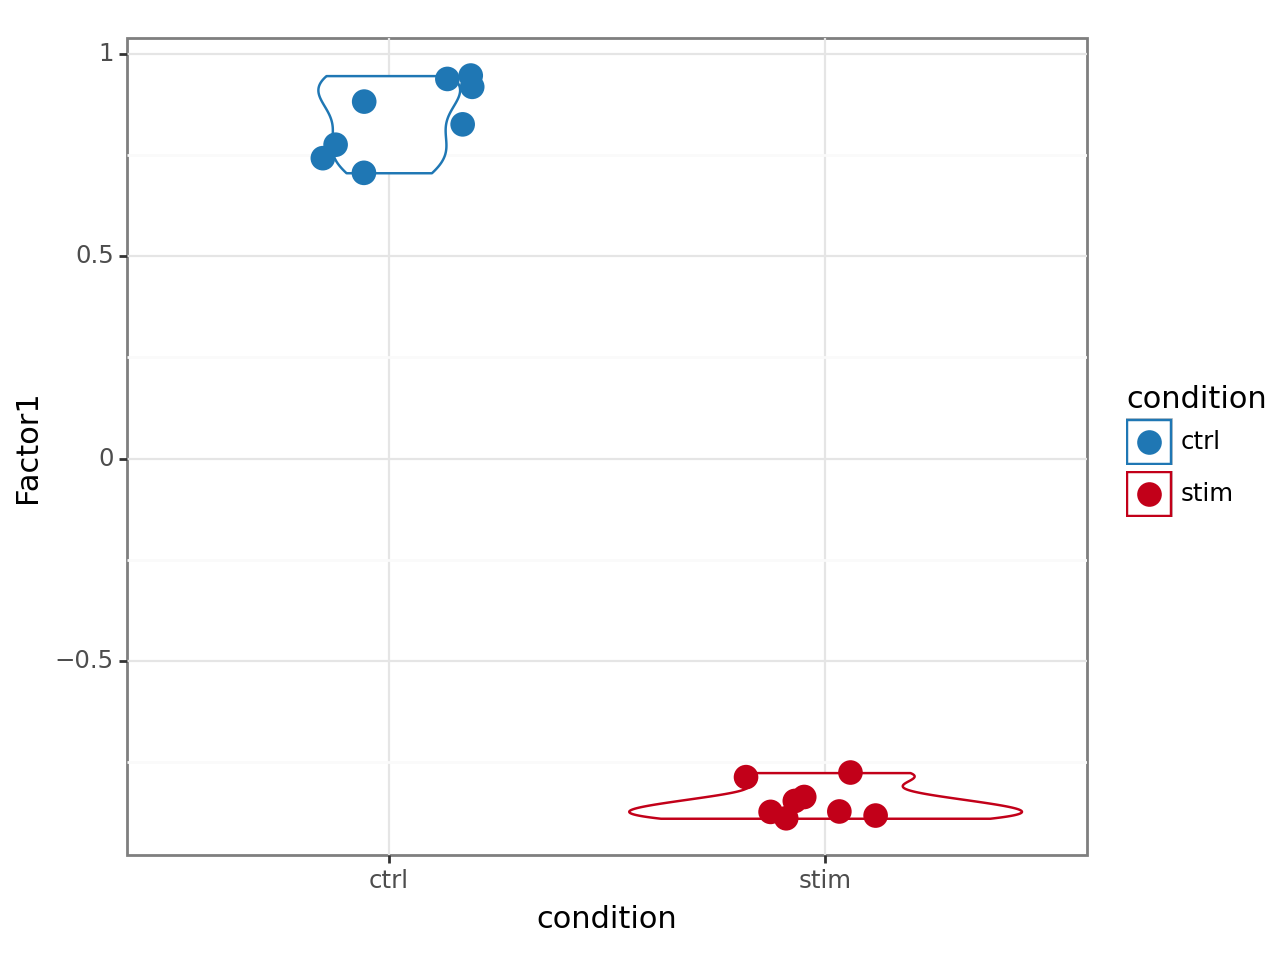

<Figure Size: (640 x 480)>

In [91]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw() +
 p9.scale_colour_manual(values=['#1f77b4', '#c20019'])
 )

In [92]:
variable_loadings =  li.ut.get_variable_loadings(mdata, varm_key='LFs', view_sep=':') # get loadings
# order features by absolute value for Factor 1
variable_loadings = variable_loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False)
variable_loadings.head()

,view,variable,Factor1,Factor2,Factor3,Factor4,Factor5
308,CD14+ Monocytes,CCL8,-2.253089,-0.446240,-0.399569,0.431196,0.033334
507,CD14+ Monocytes,CXCL10,-2.223876,-0.140707,0.240957,0.552299,-0.091137
508,CD14+ Monocytes,CXCL11,-2.034445,0.482461,-0.132775,0.506777,-0.291462
10302,FCGR3A+ Monocytes,CXCL11,-1.999377,0.001245,0.492599,0.060890,-0.028669
950,CD14+ Monocytes,IFIT1,-1.993360,0.678030,0.655885,0.205603,0.192994


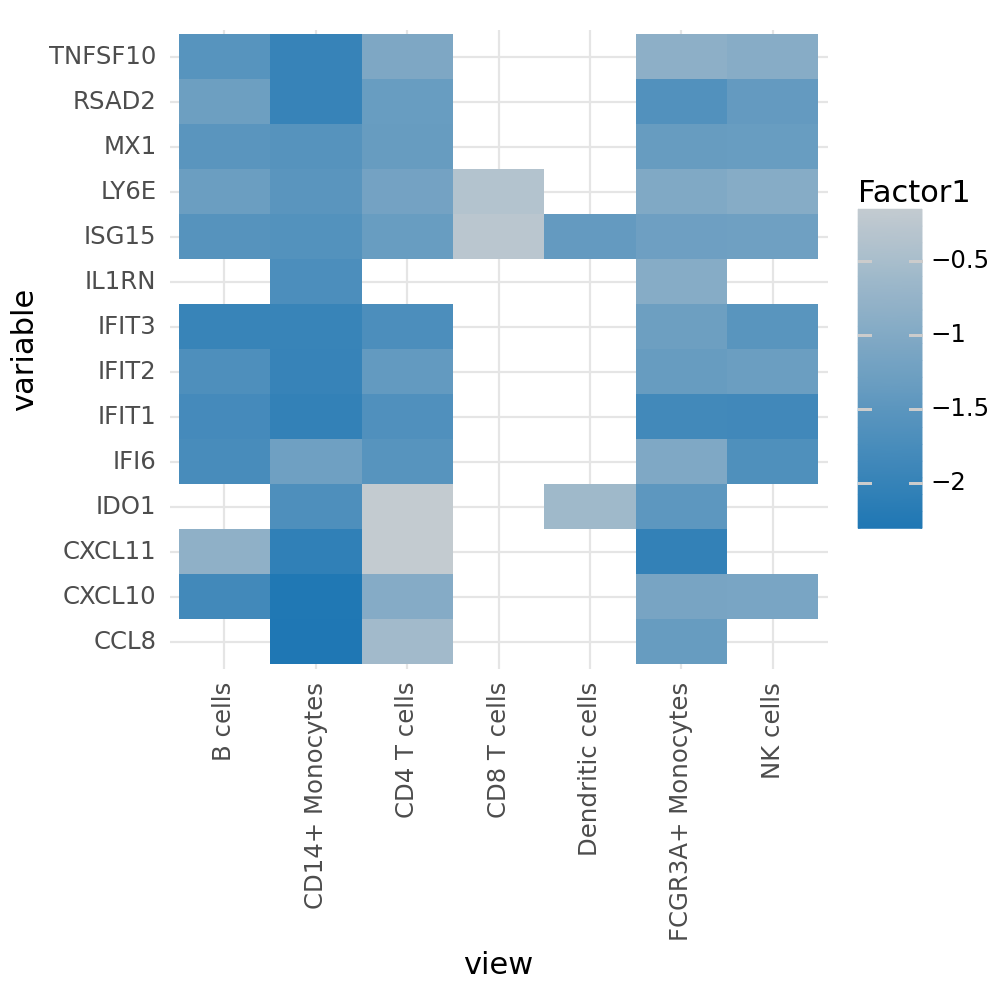

<Figure Size: (500 x 500)>

In [93]:
# get top genes with highest absolute loadings across all views
top_genes = variable_loadings['variable'].head(30)
top_loadings = variable_loadings[variable_loadings['variable'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

# plot them
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) +
 p9.aes(x='view', y='variable', fill='Factor1') +
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') +
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5), figure_size=(5, 5))
 )